In [2]:
import numpy as np
np.set_printoptions(precision=6,suppress=True)
from triqs.plot.mpl_interface import plt,oplot

from h5 import HDFArchive
from triqs.gf import BlockGf

from triqs_dft_tools.converters.vasp import VaspConverter 
import triqs_dft_tools.converters.plovasp.converter as plo_converter

import pymatgen.io.vasp.outputs as vio
from pymatgen.electronic_structure.dos import CompleteDos
from pymatgen.electronic_structure.core import Spin, Orbital, OrbitalType

import warnings 
warnings.filterwarnings("ignore") #ignore some matplotlib warnings

Starting serial run at: 2022-02-25 08:11:24.095391


# AFM state of NiO with one-shot DMFT from Vasp

In this tutorial we will take a look at a magnetic DMFT calculation for NiO in the antiferromagnetic phase. NiO is known to undergo a magnetic transition at around 525 K resulting in an AFM type II order, with all 180 degree Ni-0-Ni bonds to order anti-ferromagnetically. 

This tutorial will guide you through the following steps: 

* run a non-magnetic Vasp calculation for NiO with a two atom unit cell
* create projectors in a large energy window for all Ni-$d$ orbitals and all O-$p$ orbitals
* create the hdf5 input via the Vasp converter for solid_dmft
* run a high temperature paramagnetic calculation and a low temperature AFM calculation
* take a look at the output

Warning: the DMFT calculations here are very heavy requiring ~700 core hours per DMFT job.


## 1. Run DFT 

The tutorial is based on the NiO example from [DFTTools](https://triqs.github.io/dft_tools/unstable/tutorials/nio_csc.html), but is more advanced by allowing to acccess the magnetic state of the system. 

We start by running Vasp to create the raw projectors. The [INCAR](INCAR), [POSCAR](POSCAR), and [KPOINTS](KPOINTS) file are kept relatively simple. For the POTCAR the standard `PBE Ni` and `PBE O` pseudo potentials are used. Here we make sure that the Kohn-Sham eigenstates are converged well (rms), hence we do quite a few extra SCF steps here by setting `NELMIN=30`. We tell Vasp to create projectors for the Ni d shell by setting the INCAR flag `LOCPROJ = LOCPROJ = 1 2 : d : Pr`. More information can be found on the [DFTTools webpage of the Vasp converter](https://triqs.github.io/dft_tools/unstable/guide/conv_vasp.html).

Let's run Vasp with 
```
mpirun vasp_std 1>out 2>err &
```
and monitor the output. After Vasp is finished the result should look like this: 

In [82]:
!tail -n 10 vasp.out

DAV:  30    -0.226809711331E+02    0.20827E-09    0.80041E-14 28416   0.286E-07    0.535E-08
DAV:  31    -0.226809711332E+02   -0.10186E-09    0.13035E-13 28032   0.190E-07    0.384E-08
DAV:  32    -0.226809711325E+02    0.69713E-09    0.13333E-13 27480   0.106E-07    0.229E-08
DAV:  33    -0.226809711323E+02    0.23601E-09    0.91588E-14 27616   0.699E-08    0.789E-09
DAV:  34    -0.226809711333E+02   -0.10236E-08    0.21298E-13 27368   0.465E-08    0.780E-09
DAV:  35    -0.226809711324E+02    0.91086E-09    0.83940E-14 27208   0.305E-08    0.626E-09
DAV:  36    -0.226809711323E+02    0.93678E-10    0.39223E-14 27056   0.192E-08
 LOCPROJ mode
 Computing AMN (projections onto localized orbitals)
   1 F= -.22680971E+02 E0= -.22669554E+02  d E =-.228342E-01


let us take a look at the density of states from Vasp:

In [83]:
vasprun = vio.Vasprun('vasprun.xml')
dos = vasprun.complete_dos
Ni_spd_dos = dos.get_element_spd_dos("Ni")
O_spd_dos = dos.get_element_spd_dos("O")

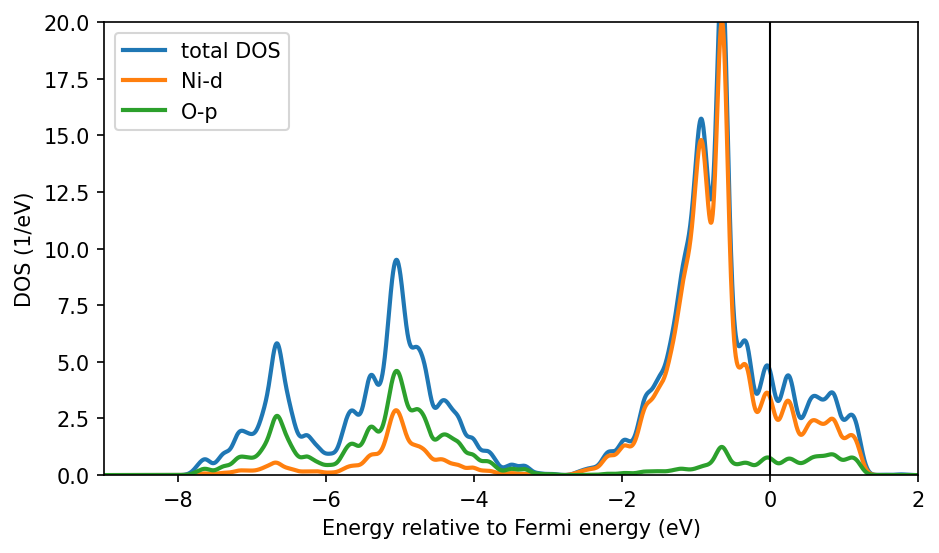

In [84]:
fig, ax = plt.subplots(1,dpi=150,figsize=(7,4))

ax.plot(vasprun.tdos.energies - vasprun.efermi , vasprun.tdos.densities[Spin.up], label=r'total DOS', lw = 2) 
ax.plot(vasprun.tdos.energies - vasprun.efermi , Ni_spd_dos[OrbitalType.d].densities[Spin.up], label=r'Ni-d', lw = 2) 
ax.plot(vasprun.tdos.energies - vasprun.efermi , O_spd_dos[OrbitalType.p].densities[Spin.up], label=r'O-p', lw = 2) 

ax.axvline(0, c='k', lw=1)
ax.set_xlabel('Energy relative to Fermi energy (eV)')
ax.set_ylabel('DOS (1/eV)')
ax.set_xlim(-9,2)
ax.set_ylim(0,20)
ax.legend()
plt.show()

## 2. Creating the hdf5 archive / DMFT input

Next we run the [Vasp converter](https://triqs.github.io/dft_tools/unstable/guide/conv_vasp.html) to create an input h5 archive for solid_dmft. The [plo.cfg](plo.cfg) looks like this: 

In [5]:
!cat plo.cfg

[General]
BASENAME = nio

[Group 1]
SHELLS = 1
EWINDOW = -9 2
NORMALIZE = True

[Shell 1] # Ni d shell
LSHELL = 2
IONS = 1 2
CORR = True



we create $d$ like projectors within a large energy window from -9 to 2 eV for very localized states for both Ni sites. Important: the sites are markes as non equivalent, so that we can later have different spin orientations on them. 

Let's run the converter:

In [6]:
# Generate and store PLOs
plo_converter.generate_and_output_as_text('plo.cfg', vasp_dir='./')

# run the archive creat routine
conv = VaspConverter('nio')
conv.convert_dft_input()

!!! WARNING !!!: Error reading E-Fermi from LOCPROJ, trying DOSCAR
Read parameters:
0  ->  {'label': 'dxy', 'isite': 1, 'l': 2, 'm': 0}
1  ->  {'label': 'dyz', 'isite': 1, 'l': 2, 'm': 1}
2  ->  {'label': 'dz2', 'isite': 1, 'l': 2, 'm': 2}
3  ->  {'label': 'dxz', 'isite': 1, 'l': 2, 'm': 3}
4  ->  {'label': 'dx2-y2', 'isite': 1, 'l': 2, 'm': 4}
5  ->  {'label': 'dxy', 'isite': 2, 'l': 2, 'm': 0}
6  ->  {'label': 'dyz', 'isite': 2, 'l': 2, 'm': 1}
7  ->  {'label': 'dz2', 'isite': 2, 'l': 2, 'm': 2}
8  ->  {'label': 'dxz', 'isite': 2, 'l': 2, 'm': 3}
9  ->  {'label': 'dx2-y2', 'isite': 2, 'l': 2, 'm': 4}
  Found POSCAR, title line: Ni2 O2
  Total number of ions: 4
  Number of types: 2
  Number of ions for each type: [2, 2]

    Total number of k-points: 729
  No tetrahedron data found in IBZKPT. Skipping...
eigvals from LOCPROJ

  Unorthonormalized density matrices and overlaps:
  Spin: 1
  Site: 1
  Density matrix                                                  Overlap
   1.6802167  -0

We note that the resulting density matrix and local Hamiltian off the d-shell seems to be quite off-diagonal. This is because in Vasp local projections are always done with respect to cartesian axis, and hence the unit cell here is non cubic the oxygen octahedra are rotated in the cell, leading to projectors resulting in off-diagonal occupations. We will correct for that in the next step when we run DMFT.  

## 3. Running the high temperature PM calculation

The prepared confilg file [config_highT.ini](config_highT.ini) looks like this:

    [general]
    seedname = nio
    jobname = NiO_highT

    block_threshold = 0.001
    set_rot = hloc

    solver_type = cthyb
    n_iw = 501 

    prec_mu = 0.001

    h_int_type = density_density
    U = 8.0
    J = 1.0

    beta = 5

    magnetic = True
    magmom = 0.0001, 0.0001
    afm_order = True

    n_iter_dmft = 10

    g0_mix_type = linear
    g0_mix = 0.8

    dc_type = 0
    dc = True
    dc_dmft = False

    [solver]
    length_cycle = 300
    n_warmup_cycles = 10000
    n_cycles_tot = 3e+7
    delta_interface = True
    imag_threshold = 1e-5
    off_diag_threshold = 1e-3

    perform_tail_fit = True
    fit_max_moment = 4
    fit_min_w = 8
    fit_max_w = 14



Let's go through some special options we set in the config file: 

* we changed `n_iw=501` because at higher temperatures we need less Matsubara frequencies
* with `set_rot=hloc` solid_dmft will rotate the projectors into a basis that diagonalizes the non-interacting local Hamiltonian before doing the calculation. Ensuring that we have the desired diagonal orbital structure.  
* `h_int_type` is set to `density_density` to reduce complexity of the problem
* `beta=5` here we set the temperature to ~2300K
* `magnetic=True` lift spin degeneracy
* `magmom` here we specify the magnetic order. Here, we say that both Ni sites have the same spin, which should average to 0 at this high temperature. The magnetic moment is specified in units of the DC potential. Hence, small values should be chosen. 
* `afm_order=True` tells solid_dmft to not solve impurities with the same `magmom` but rather copy the self-energy and if necessary flip the spin
* with `dc_type=0` we select the FLL double counting. The result will heavily depend in NiO on the DC scheme [1](https://doi.org/10.1016/j.elspec.2010.05.021)
* `length_cycle=300` is the length between two Green's function measurements in cthyb. This number has to be choosen carefully to give an autocorrelation time <1
* here we use tail fitting to get good high frequency self-energy behavior: `perform_tail_fit=True` 

By setting the flag magmom to a small value with the same sign on both sites we tell solid_dmft that both sites are equivalent. We see in the low temperature example how we can use this to enfore a antiferromagnetic order. Now we run solid_dmft simply by executing `mpirun solid_dmft config_highT.ini` . 

Caution: this is a very heavy job and will take roughly ~ 650 core hours, which should be submitted on a cluster. 

In the beginning of the calculation you should find information that solid_dmft diagonalizes `Hloc_0` to rotate all properties. TThe new rotation matrices `rot_mat` are being printed. The following density matrix should be mostly diagonal: 

    DFT density matrix
    rho[ 0]                           up                                           down                    
                 0.97707 -0.00000  0.00000 -0.00050 -0.00211    0.97707 -0.00000  0.00000 -0.00050 -0.00211
                -0.00000  0.97707 -0.00000  0.00210 -0.00050   -0.00000  0.97707 -0.00000  0.00210 -0.00050
                 0.00000 -0.00000  0.97699  0.00000 -0.00000    0.00000 -0.00000  0.97699  0.00000 -0.00000
                -0.00050  0.00210  0.00000  0.67124  0.00000   -0.00050  0.00210  0.00000  0.67124  0.00000
                -0.00211 -0.00050 -0.00000  0.00000  0.67125   -0.00211 -0.00050 -0.00000  0.00000  0.67125

and the same for up/down, because the DFT calculation is performed without magnetism as all magnetism is thought to arise within the Ni-$d$ shell. Further below we find the following lines:

    AFM calculation selected, mapping self energies as follows:
    imp  [copy sigma, source imp, switch up/down]
    ---------------------------------------------
    0: [False, 0, False]
    1: [True, 0, False]

this tells us that solid_dmft detected correctly how we want to orientate the spin moments. This also reflects itself during the iterations when the second impurity problem should be solved. But instead of solving solid_dmft copies all properties of the first impurity and if neccessary flips the spin channel: 

    ...
    copying the self-energy for shell 1 from shell 0
    inverting spin channels: False
    ...

After the calculation is finished we can take a look at the results:

In [114]:
with HDFArchive('NiO_highT/nio.h5','r') as h5:
    Sigma_iw_highT = h5['DMFT_results/last_iter/Sigma_freq_0']
    obs_highT = h5['DMFT_results/observables']

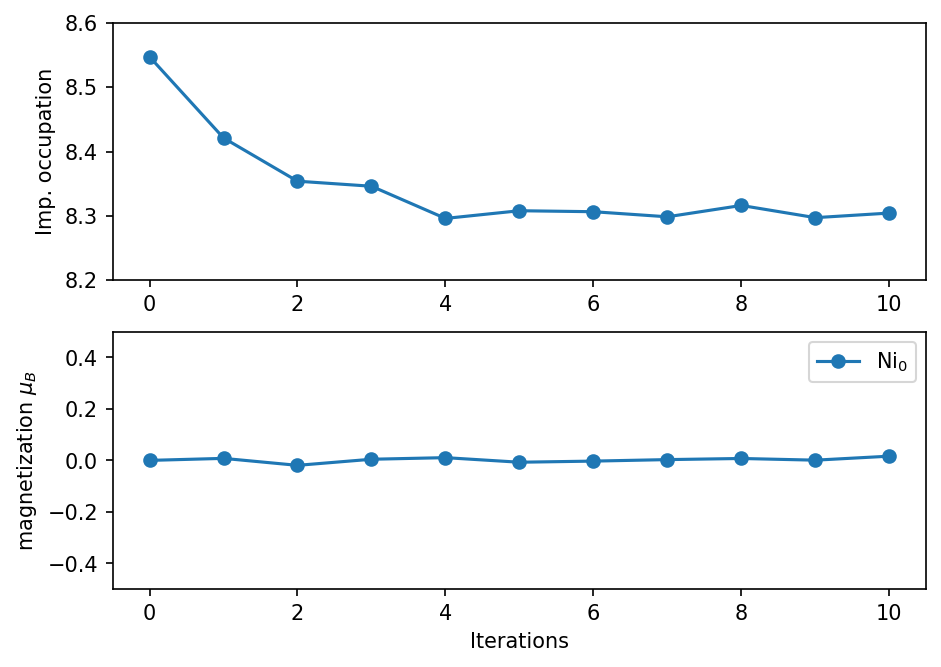

In [98]:
fig, ax = plt.subplots(nrows=2, dpi=150, figsize=(7,5))

ax[0].plot(obs_highT['iteration'], np.array(obs_highT['imp_occ'][0]['up'])+np.array(obs_highT['imp_occ'][0]['down']), '-o', label=r'Ni$_0$')

ax[1].plot(obs_highT['iteration'], (np.array(obs_highT['imp_occ'][0]['up'])-np.array(obs_highT['imp_occ'][0]['down'])), '-o', label=r'Ni$_0$')


ax[0].set_ylabel('Imp. occupation')
ax[1].set_ylabel(r'magnetization $\mu_B$')
ax[0].set_ylim(8.2, 8.6)
ax[1].set_ylim(-0.5, 0.5)
ax[-1].set_xlabel('Iterations')
ax[1].legend()
plt.show()

We see that the impurity occupation converges after 4 iterations to around 8.3 electrons per Ni site. Since we have a large energy window with other states in the energy window besides the Ni-$d$ states, charge is exchanged with the bath. Only the occupation of the band basis lattice Green's function is fixed to n=28. The second plot shows the magnetization of the Ni site, which fluctuates around 0. We can also take a look at the resulting self-energies:

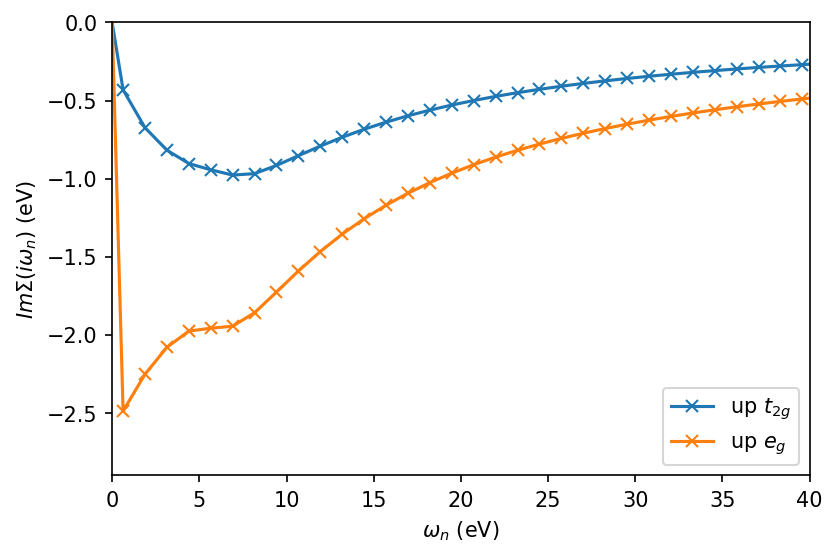

In [95]:
fig, ax = plt.subplots(1,dpi=150)

ax.oplot(Sigma_iw_highT['up_0'][0,0].imag, '-x', label=r'up $t_{2g}$')
ax.oplot(Sigma_iw_highT['up_0'][1,1].imag, '-x',label=r'up $e_{g}$')

ax.set_ylabel(r"$Im \Sigma (i \omega_n)$ (eV)")
ax.set_xlabel(r"$\omega_n$ (eV)")

ax.set_xlim(0,40)
ax.set_ylim(-2.9,0)
ax.legend()
plt.show()

We can clearly see that a $\omega_n=8$ the self-energy is replaced by the tail-fit as specified in the input config file. This cut is rather early, but ensures convergence. For higher sampling rates this has to be changed. We also observe that for $i \omega_n$->0 the e$_g$ orbital self-energy shows an continuously increasing value indicating an insulating solution. In contrast the t$_{2g}$ orbital self-energy approaches smoothly 0 for $i \omega_n$->0 indicating a metallic solution with some renormalization. 

## 4. Running the low temperature PM calculation

now we run the low temperature calculation at around 390 K, well below the ordering temperature of NiO. We change only a few things in the config file [config_lowT.ini](config_lowT.ini). We change: 

* `beta=30`
* `magmom=-0.01, 0.01` 
* `measure_density_matrix = True ` measures the impurity many-body density matrix in the Fock basis for a multiplet analysis

and a few other numerical parameters for the solver. We run this example as well via `mpirun solid_dmft config_lowT.ini`. Now the magnetic setup looks like this: 

    AFM calculation selected, mapping self energies as follows:
    imp  [copy sigma, source imp, switch up/down]
    ---------------------------------------------
    0: [False, 0, False]
    1: [True, 0, True]

Meaning that now the spin will be flipped from the first to the second impurity. Furthermore, we can observe right in the first iteration that the occupation matrix favors the up spin channel (compare down_0 vs up_0 block)

    down_0, real part
    [[0.98415624 0.00468119]
     [0.00468119 0.3657067 ]]
    ...
    up_0, real part
    [[ 0.99667026 -0.00151364]
     [-0.00151364  0.9085364 ]]
    ...

this should initialize the calculation enough to give a magnetic solution.


Let's take a look at the results:

In [137]:
with HDFArchive('NiO_lowT/nio.h5','r') as h5:
    Sigma_iw_lowT = h5['DMFT_results/last_iter/Sigma_freq_0']
    obs_lowT = h5['DMFT_results/observables']

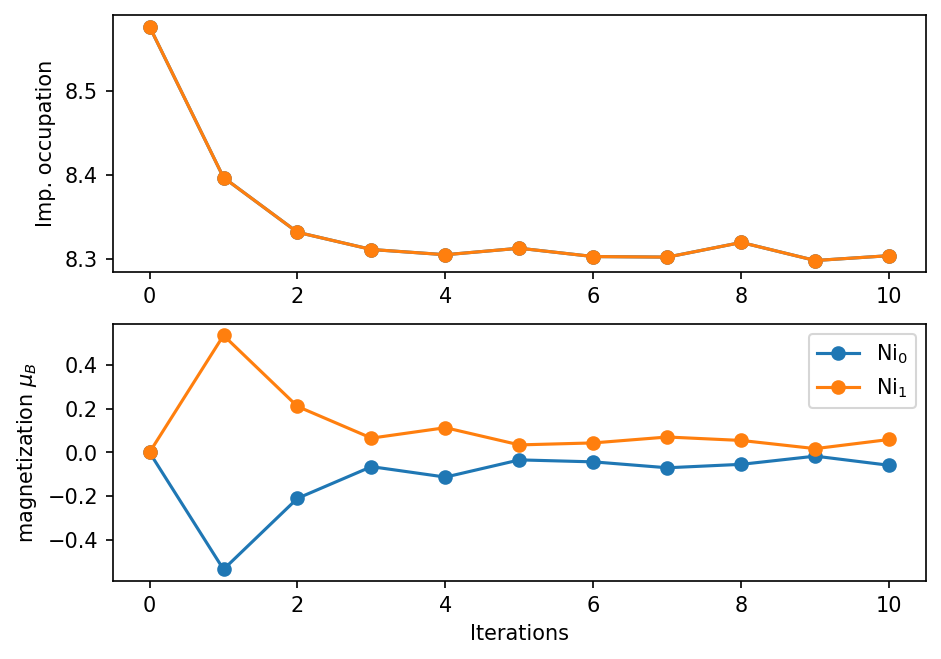

In [138]:
fig, ax = plt.subplots(nrows=2, dpi=150, figsize=(7,5))

ax[0].plot(obs_lowT['iteration'], np.array(obs_lowT['imp_occ'][0]['up'])+np.array(obs_lowT['imp_occ'][0]['down']), '-o', label=r'Ni$_0$')
ax[0].plot(obs_lowT['iteration'], np.array(obs_lowT['imp_occ'][1]['up'])+np.array(obs_lowT['imp_occ'][1]['down']), '-o', label=r'Ni$_1$')

ax[1].plot(obs_lowT['iteration'], (np.array(obs_lowT['imp_occ'][0]['up'])-np.array(obs_lowT['imp_occ'][0]['down'])), '-o', label=r'Ni$_0$')
ax[1].plot(obs_lowT['iteration'], (np.array(obs_lowT['imp_occ'][1]['up'])-np.array(obs_lowT['imp_occ'][1]['down'])), '-o', label=r'Ni$_1$')

ax[0].set_ylabel('Imp. occupation')
ax[1].set_ylabel(r'magnetization $\mu_B$')
# ax[0].set_ylim(8.2, 8.7)
# ax[1].set_ylim(-0.5, 0.5)
ax[-1].set_xlabel('Iterations')
ax[1].legend()

plt.show()

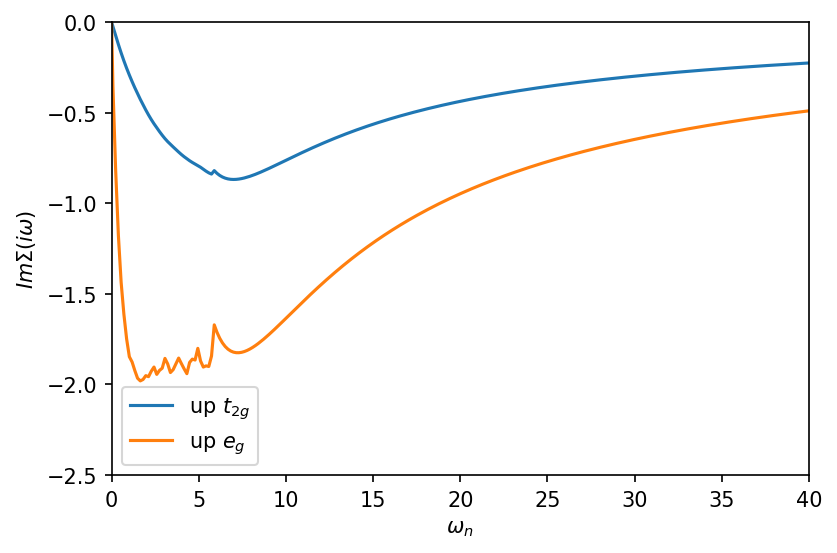

In [139]:
fig, ax = plt.subplots(1,dpi=150)

ax.oplot(Sigma_iw_lowT['up_0'][0,0].imag, '-', label=r'up $t_{2g}$')
ax.oplot(Sigma_iw_lowT['up_4'][0,0].imag, '-',label=r'up $e_{g}$')

ax.set_ylabel(r"$Im \Sigma (i \omega)$")

ax.set_xlim(0,40)
ax.set_ylim(-2.5,0)
ax.legend()
plt.show()

## 5. Multiplet analysis